In [1]:
# Copyright 2019 Steven Mattis and Troy Butler
import numpy as np
import matplotlib.pyplot as plt
import dynamical_systems as ds
from luq import *

Model is for harmonic motion
$$y''(t) + 2cy'(t) + \omega_0^2 x = f(t)$$
with damping constant
$$c \in [0.1,1]$$
and natural frequency
$$\omega_0\in[0.5,2]$$
and forcing term initially taken to be zero.

Note that with the ranges of $c$ and $\omega_0$ above, it is possible for the system to either be under-, over-, or critically damped (and since $c\geq 0.1$ it is never undamped, which is almost always physical nonsense). 

The roots to the characteristic equation are given by
$$ r_1 = -c\pm \sqrt{c^2-\omega_0^2}$$.

When the system is under-damped, the solution is given by
$$ y(t) = e^{-ct}[C_1\cos(\omega t) + C_2\sin(\omega t)], \ \omega=\sqrt{\omega_0^2-c^2}. $$


When the system is over-damped, the solution is given by 
$$ y(t) = C_1 e^{r_1t}+C_2 e^{r_2t}. $$

And, finally, when the system is critically damped, the solution is given by
$$ y(t) = C_1e^{-ct} + C_2 te^{-ct}. $$

However, we never expect the system to be critically damped in practice since this is "too fine-tuned" of a scenario. 

The constants $C_1$ and $C_2$ are determined by the initial conditions, which we assume to be given by
$$ y(0)=a, y'(0) = b $$
where 
$$ a\in[1,2] $$ 
and 
$$ b\in[-1,0] $$. 

In the under-damped case, 
$$ C_1 = a, \ \text{and } \ C_2 = \frac{b+ca}{\omega}. $$

In the over-damped case, 
$$ C_1 = \frac{b-ar_2}{r_1-r_2}, \ \text{and } \ C_2 = \frac{b-r_1a}{r_2-r_1} $$

A ***true*** distribution of $c, \omega_0, a$, and $b$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [2]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set
num_samples = int(1E3)

params = np.random.uniform(size=(num_samples, 2))
ics = np.random.uniform(size=(num_samples, 2))

params[:, 0] = 0.1 + 0.4 * params[:, 0]  # c
params[:, 1] = 0.5 + 1.5 * params[:, 1]  # omega_0
ics[:, 0] = 1 + 1 * ics[:, 0]  # a
ics[:, 1] = -1 + 1 * ics[:, 1]   # b

# Construct the predicted time series data

num_time_preds = int(50)  # number of predictions (uniformly space) between [time_start,time_end]
time_start = 0.5
time_end = 3.5
times = np.linspace(time_start, time_end, num_time_preds)

phys = ds.HarmonicOscillator()
predicted_time_series = phys.solve(ics=ics, params=params, t_eval=times)


# Simulate an observed Beta distribution of time series data

num_obs = int(1E3)

true_a = 2
true_b = 2

params_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
ics_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)

params_obs[:, 0] = 0.1 + 0.4 * params_obs[:, 0]  # c
params_obs[:, 1] = 0.5 + 1.5 * params_obs[:, 1]  # omega_0
ics_obs[:, 0] = 1 + 1 * ics_obs[:, 0]  # a
ics_obs[:, 1] = -1 + 1 * ics_obs[:, 1]   # b

observed_time_series = phys.solve(ics=ics_obs, params=params_obs, t_eval=times)


# Add noise if desired
with_noise = False
noise_stdev = 0.05

if with_noise:
    observed_time_series += noise_stdev * np.random.randn(num_obs)

In [3]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 0
time_end_idx = 49

# Clean data
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                     num_clean_obs=50, tol=1.0e-2, min_knots=5, max_knots=15)

0 6 0.03132973607672583
0 7 0.02140847313449546
0 8 0.015954684912631693
0 9 0.013764421752362827
0 10 0.0112522378846493
0 11 0.009657455270026252
0 12 0.008073889923164285
0 13 0.006455102551398088
0 13 knots being used with error of 0.006455102551398088
1 6 0.013767632764325077
1 7 0.01010640260059526
1 8 0.008987643009926896
1 9 0.006687579813702649
1 10 0.005607838786260269
1 10 knots being used with error of 0.005607838786260269
2 6 0.021965074939644707
2 7 0.014617537578485534
2 8 0.012372714536112004
2 9 0.010633568465999006
2 10 0.008425097076255793
2 11 0.0076002250094629135
2 12 0.00729455142528645
2 12 knots being used with error of 0.00729455142528645
3 6 0.013325387547371451
3 7 0.011389937517411535
3 8 0.0075163059349073235
3 9 0.00571456570811639
3 9 knots being used with error of 0.00571456570811639
4 6 0.010291301689312447
4 7 0.006895844956670997
4 8 0.004993642946999886
4 8 knots being used with error of 0.004993642946999886
5 6 0.0054495584971244355
5 6 knots being

/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


9 12 0.007773008270203723
9 12 knots being used with error of 0.007773008270203723
10 6 0.0037025152918849368
10 6 knots being used with error of 0.0037025152918849368
11 6 0.010840813336323536
11 7 0.007174830034636278
11 8 0.004963842925348198
11 8 knots being used with error of 0.004963842925348198
12 6 0.005336308239015553
12 6 knots being used with error of 0.005336308239015553
13 6 0.005880861938832482
13 7 0.003987838281397111
13 7 knots being used with error of 0.003987838281397111
14 6 0.009391989686001167
14 7 0.006284155800026328
14 7 knots being used with error of 0.006284155800026328
15 6 0.0035065219648222324
15 6 knots being used with error of 0.0035065219648222324
16 6 0.025854474871184207
16 7 0.02541800269683569
16 8 0.014762489915418061
16 9 0.012523899193097902
16 10 0.011485675030082871
16 11 0.008963332062981954
16 12 0.00818555244365193
16 12 knots being used with error of 0.00818555244365193
17 6 0.008477013440237938
17 7 0.005903952102362726
17 7 knots being us

63 9 0.014598981567069439
63 10 0.01217509288199043
63 11 0.01016258216166572
63 12 0.008958102217228871
63 12 knots being used with error of 0.008958102217228871
64 6 0.01282424631411809
64 7 0.008448891950994063
64 8 0.005972853475313394
64 9 0.004749226423066072
64 9 knots being used with error of 0.004749226423066072
65 6 0.021848650460142324
65 7 0.013448683978273802
65 8 0.010536813174030992
65 9 0.01083524804446185
65 10 0.009203742774308774
65 11 0.00693360586143422
65 12 0.005774933389875616
65 12 knots being used with error of 0.005774933389875616
66 6 0.010773863810000249
66 7 0.007531716100929212
66 7 knots being used with error of 0.007531716100929212
67 6 0.02180242497424141
67 7 0.014722390932023165
67 8 0.012595399729116191
67 9 0.010275459152300279
67 10 0.008776359739764508
67 11 0.008793824912360497
67 12 0.006846298306143366
67 13 0.00538004894166195
67 13 knots being used with error of 0.00538004894166195
68 6 0.024715931168187755
68 7 0.013699552146093153
68 8 0.0

110 12 0.007935459747741716
110 12 knots being used with error of 0.007935459747741716
111 6 0.004962527621188228
111 6 knots being used with error of 0.004962527621188228
112 6 0.02708269211720049
112 7 0.02029616182659941
112 8 0.015209395042304064
112 9 0.012439859894364087
112 10 0.010020897954005537
112 11 0.008601207394591965
112 12 0.0070510691559167345
112 12 knots being used with error of 0.0070510691559167345
113 6 0.001481878476211004
113 6 knots being used with error of 0.001481878476211004
114 6 0.022946243417797375
114 7 0.01634006010049157
114 8 0.013874806352811377
114 9 0.011102520659761153
114 10 0.00874773931981663
114 11 0.008798747736180121
114 12 0.0069570537063836
114 12 knots being used with error of 0.0069570537063836
115 6 0.008013206450437202
115 6 knots being used with error of 0.008013206450437202
116 6 0.013250365908734216
116 7 0.009491245334491518
116 8 0.008033241244576725
116 9 0.0073298018793700155
116 10 0.00641298271073354
116 11 0.00501594943383474

155 6 0.01560908745256153
155 7 0.012050248996411229
155 8 0.008170273932626242
155 9 0.006555243349588706
155 10 0.005614503531990846
155 10 knots being used with error of 0.005614503531990846
156 6 0.004213667096248877
156 6 knots being used with error of 0.004213667096248877
157 6 0.002593020006336306
157 6 knots being used with error of 0.002593020006336306
158 6 0.021940266358449118
158 7 0.015223821680385335
158 8 0.015383344152120131
158 9 0.01081371483308815
158 10 0.008631550599685
158 11 0.008590389418921568
158 12 0.006823625555143079
158 12 knots being used with error of 0.006823625555143079
159 6 0.013028812571059171
159 7 0.009855301800706437
159 8 0.00659314384524878
159 9 0.005251708834667893
159 9 knots being used with error of 0.005251708834667893
160 6 0.024762099328696826
160 7 0.018092055979412634
160 8 0.013966931447203025
160 9 0.011963863821379225
160 10 0.009115002584795851
160 11 0.008276216164784238
160 12 0.007874488387215137
160 12 knots being used with err

203 6 0.02297771005011246
203 7 0.015255196900132629
203 8 0.014979015627895886
203 9 0.01040561582212448
203 10 0.0082343777250425
203 11 0.00690024780770467
203 11 knots being used with error of 0.00690024780770467
204 6 0.028388473141335156
204 7 0.02383130516693447
204 8 0.01632898262391715
204 9 0.012956720443505994
204 10 0.010900611762493455
204 11 0.009061596043149156
204 12 0.0077199968435342214
204 12 knots being used with error of 0.0077199968435342214
205 6 0.00704779448429734
205 7 0.004888736692781596
205 7 knots being used with error of 0.004888736692781596
206 6 0.016514420573846098
206 7 0.011149227847963045
206 8 0.009906921793380886
206 9 0.0073205444846876095
206 10 0.006211230985456014
206 11 0.005045350602642604
206 11 knots being used with error of 0.005045350602642604
207 6 0.024513821762860107
207 7 0.015190237665906816
207 8 0.011747722896936773
207 9 0.00985759103858189
207 10 0.008251582580017345
207 11 0.00681630109264235
207 12 0.005682633144165191
207 12 

251 6 0.0031517171427521513
251 6 knots being used with error of 0.0031517171427521513
252 6 0.004346665339251737
252 6 knots being used with error of 0.004346665339251737
253 6 0.04119295204988473
253 7 0.028375859489706834
253 8 0.0209275036030794
253 9 0.01651019044639714
253 10 0.013388475092683826
253 11 0.010834452343313863
253 12 0.009117731080209492
253 13 0.0076896724567446055
253 13 knots being used with error of 0.0076896724567446055
254 6 0.029461121543047555
254 7 0.021064248553701533
254 8 0.015171256798818014
254 9 0.012616680426002213
254 10 0.01005566469485406
254 11 0.008554311801666516
254 12 0.0076075965984034755
254 12 knots being used with error of 0.0076075965984034755
255 6 0.024818242262358067
255 7 0.01576069873833787
255 8 0.012218194384063399
255 9 0.00988233089509308
255 10 0.008178296390958453
255 11 0.0067873983646761105
255 12 0.005581405603413787
255 12 knots being used with error of 0.005581405603413787
256 6 0.02350120603227442
256 7 0.015376255329291

298 13 0.006982478127370259
298 13 knots being used with error of 0.006982478127370259
299 6 0.021153806606122767
299 7 0.013444438521702231
299 8 0.010876052165287127
299 9 0.009610497736950047
299 10 0.009366153805468257
299 11 0.0070709655639000345
299 12 0.0059953773672029535
299 12 knots being used with error of 0.0059953773672029535
300 6 0.01081784331724577
300 7 0.007184129642859201
300 8 0.004979724138566623
300 8 knots being used with error of 0.004979724138566623
301 6 0.02436965743794285
301 7 0.01647526774113821
301 8 0.013280388800323643
301 9 0.010252887386038146
301 10 0.008570974605818436
301 11 0.007322926875221767
301 12 0.006307229419778422
301 12 knots being used with error of 0.006307229419778422
302 6 0.015160242871302848
302 7 0.010349614528322173
302 8 0.00743193042548509
302 9 0.005716125576609249
302 9 knots being used with error of 0.005716125576609249
303 6 0.014611940916876127
303 7 0.009110594936608303
303 8 0.0062117672992373155
303 9 0.00503217581927422

348 12 0.009352542915616182
348 13 0.00765018549565993
348 13 knots being used with error of 0.00765018549565993
349 6 0.01645067416116252
349 7 0.011623720123065902
349 8 0.009771644280865341
349 9 0.007185745647124578
349 10 0.005874391537352042
349 11 0.004838672240178063
349 11 knots being used with error of 0.004838672240178063
350 6 0.0013371251823414562
350 6 knots being used with error of 0.0013371251823414562
351 6 0.0011751414985259076
351 6 knots being used with error of 0.0011751414985259076
352 6 0.024724092467412886
352 7 0.01583086942000013
352 8 0.011108984291863565
352 9 0.008786459299560978
352 10 0.008224936845455166
352 11 0.006442133680020737
352 12 0.005401750376132136
352 12 knots being used with error of 0.005401750376132136
353 6 0.00743604430623693
353 6 knots being used with error of 0.00743604430623693
354 6 0.007722373940634546
354 7 0.0059344419898830145
354 7 knots being used with error of 0.0059344419898830145
355 6 0.0030334792629507805
355 6 knots bein

399 10 0.005131667372890188
399 10 knots being used with error of 0.005131667372890188
400 6 0.008647025741813752
400 7 0.005920375556875321
400 7 knots being used with error of 0.005920375556875321
401 6 0.013813048425134956
401 7 0.010686249325864499
401 8 0.007219355191485443
401 9 0.005586134626417648
401 9 knots being used with error of 0.005586134626417648
402 6 0.0007795000859931412
402 6 knots being used with error of 0.0007795000859931412
403 6 0.03901777271447679
403 7 0.027012435044691457
403 8 0.023433332821351065
403 9 0.015567488196278012
403 10 0.013232918830135712
403 11 0.010841862687810231
403 12 0.009531606247880593
403 13 0.007475304614042857
403 13 knots being used with error of 0.007475304614042857
404 6 0.013878316725721518
404 7 0.010398133409185849
404 8 0.009800732126006562
404 9 0.007109657561923053
404 10 0.005685932107696896
404 10 knots being used with error of 0.005685932107696896
405 6 0.0014358782205723813
405 6 knots being used with error of 0.00143587

453 8 0.011346067414686722
453 9 0.008936441310645681
453 10 0.008264457764698337
453 11 0.006492552384551451
453 12 0.005456221413311984
453 12 knots being used with error of 0.005456221413311984
454 6 0.02273517186445963
454 7 0.012793545504480251
454 8 0.00965045108094603
454 9 0.008582670046140212
454 10 0.008023851600214344
454 11 0.00640476692255285
454 12 0.005424432260713484
454 12 knots being used with error of 0.005424432260713484
455 6 0.010670444570379382
455 7 0.009861562620370894
455 8 0.005699249772180538
455 9 0.004437730022668387
455 9 knots being used with error of 0.004437730022668387
456 6 0.01325294505172644
456 7 0.010211692881842578
456 8 0.007816423091883969
456 9 0.00643414127943461
456 10 0.005122328818767463
456 10 knots being used with error of 0.005122328818767463
457 6 0.01260127449143905
457 7 0.008312203177227067
457 8 0.0059170920250136445
457 9 0.004714239386005106
457 9 knots being used with error of 0.004714239386005106
458 6 0.0215040349399611
458 7

502 7 0.01860108736800643
502 8 0.013775459840284362
502 9 0.01080149076300796
502 10 0.009222541192013984
502 11 0.008263514289200854
502 12 0.006478223724209735
502 12 knots being used with error of 0.006478223724209735
503 6 0.011335823159806942
503 7 0.00862647462861732
503 8 0.006343059532514003
503 9 0.0048589430731388016
503 9 knots being used with error of 0.0048589430731388016
504 6 0.029475403906962783
504 7 0.02348364942596031
504 8 0.01567890639234698
504 9 0.012941721171170472
504 10 0.010922302737600744
504 11 0.008780891785515648
504 12 0.007673184376590249
504 12 knots being used with error of 0.007673184376590249
505 6 0.003949267635103876
505 6 knots being used with error of 0.003949267635103876
506 6 0.03751363692209739
506 7 0.025514450084523663
506 8 0.01825351945036494
506 9 0.01530846885628239
506 10 0.012732474826603963
506 11 0.010555234612300592
506 12 0.009216510455329589
506 13 0.007093183819198173
506 13 knots being used with error of 0.007093183819198173
5

550 11 0.010429081690630825
550 12 0.009425498494996243
550 13 0.007329394204448084
550 13 knots being used with error of 0.007329394204448084
551 6 0.013215498856260171
551 7 0.009521709016712175
551 8 0.006802870838685048
551 9 0.005250581376884493
551 9 knots being used with error of 0.005250581376884493
552 6 0.0007326022500362731
552 6 knots being used with error of 0.0007326022500362731
553 6 0.04063116772936724
553 7 0.02364259923439307
553 8 0.018227561650348476
553 9 0.014938753601578307
553 10 0.01244069615298604
553 11 0.010515719349764337
553 12 0.009529385418368463
553 13 0.007329256675515347
553 13 knots being used with error of 0.007329256675515347
554 6 0.010180042902011369
554 7 0.007806161553500665
554 8 0.00520602104595314
554 8 knots being used with error of 0.00520602104595314
555 6 0.005719104516676705
555 7 0.00394971451038725
555 7 knots being used with error of 0.00394971451038725
556 6 0.02395148149436299
556 7 0.015906227183110067
556 8 0.011322122563324113
5

602 11 0.007524097919368727
602 12 0.0064000567040531494
602 12 knots being used with error of 0.0064000567040531494
603 6 0.015450188209597206
603 7 0.014550541153828525
603 8 0.009400513874269463
603 9 0.007197856405042085
603 10 0.006228102202453712
603 11 0.005111380586069102
603 11 knots being used with error of 0.005111380586069102
604 6 0.024915250121079934
604 7 0.015026157099212524
604 8 0.014001812053621863
604 9 0.009034983343837389
604 10 0.007450934998834696
604 11 0.006221894211168114
604 11 knots being used with error of 0.006221894211168114
605 6 0.015658418811747968
605 7 0.010905073277502382
605 8 0.007836347921183977
605 9 0.006024974262983968
605 10 0.004997286317792255
605 10 knots being used with error of 0.004997286317792255
606 6 0.03072838091052492
606 7 0.02271985634847563
606 8 0.015930523949498888
606 9 0.012939685432478467
606 10 0.011185366417340928
606 11 0.009026286583342378
606 12 0.008095134804098129
606 13 0.006220637064879658
606 13 knots being used 

646 12 0.007594333591018934
646 12 knots being used with error of 0.007594333591018934
647 6 0.02852679578019482
647 7 0.020922927870135968
647 8 0.015773973421186777
647 9 0.012808275986466113
647 10 0.010475725223926728
647 11 0.008738096810917152
647 12 0.007732691506386764
647 12 knots being used with error of 0.007732691506386764
648 6 0.009685942067637983
648 7 0.006465793591072129
648 8 0.004441731452506961
648 8 knots being used with error of 0.004441731452506961
649 6 0.004490428805719549
649 6 knots being used with error of 0.004490428805719549
650 6 0.015236425977198386
650 7 0.013860735053047895
650 8 0.009736432256695455
650 9 0.00794631105713882
650 10 0.006410955210108515
650 10 knots being used with error of 0.006410955210108515
651 6 0.025068511316782685
651 7 0.024200054430225434
651 8 0.014013750661218363
651 9 0.011525726295270187
651 10 0.010725008922264977
651 11 0.007856055893250365
651 12 0.006645352100285858
651 12 knots being used with error of 0.0066453521002

689 6 0.005829417697537642
689 7 0.00392290533816361
689 7 knots being used with error of 0.00392290533816361
690 6 0.023782621792893796
690 7 0.015331546665736677
690 8 0.01245398891486746
690 9 0.010155904556892987
690 10 0.008420660521396641
690 11 0.007201052294365024
690 12 0.006222874994817424
690 12 knots being used with error of 0.006222874994817424
691 6 0.015434565519531806
691 7 0.010465878905325776
691 8 0.0074224095670414
691 9 0.005688844179500126
691 9 knots being used with error of 0.005688844179500126
692 6 0.001332089368205709
692 6 knots being used with error of 0.001332089368205709
693 6 0.024093585388381036
693 7 0.015476226977919437
693 8 0.010977038914267047
693 9 0.008741485646012381
693 10 0.007641892985206674
693 11 0.006206545859129645
693 11 knots being used with error of 0.006206545859129645
694 6 0.0007834556343674088
694 6 knots being used with error of 0.0007834556343674088
695 6 0.011987339976178877
695 7 0.008041082586452449
695 8 0.005703730296367985


731 9 0.010489370903596598
731 10 0.008327058599847356
731 11 0.007076657636206651
731 12 0.0065227298361288585
731 12 knots being used with error of 0.0065227298361288585
732 6 0.02146910188173637
732 7 0.014982431205175473
732 8 0.015302767776875777
732 9 0.010524840290553776
732 10 0.008880622182436824
732 11 0.007282014661734112
732 11 knots being used with error of 0.007282014661734112
733 6 0.008320908632541212
733 7 0.005364612018426395
733 7 knots being used with error of 0.005364612018426395
734 6 0.04275872407211181
734 7 0.02971748044195785
734 8 0.022467928790067364
734 9 0.017000410783131952
734 10 0.014270621504557478
734 11 0.01150287603884809
734 12 0.009323539407987294
734 13 0.007951861160281752
734 13 knots being used with error of 0.007951861160281752
735 6 0.008243920611122989
735 7 0.007530479090678295
735 7 knots being used with error of 0.007530479090678295
736 6 0.008901531664370747
736 7 0.006238291884576704
736 8 0.004489163989757647
736 8 knots being used wi

777 7 0.013753942832204645
777 8 0.011756919368159943
777 9 0.010684375593188739
777 10 0.008578329002603139
777 11 0.007077678192368022
777 12 0.006117644277909088
777 12 knots being used with error of 0.006117644277909088
778 6 0.0010706605541410442
778 6 knots being used with error of 0.0010706605541410442
779 6 0.006811308326397981
779 7 0.005272312903441273
779 7 knots being used with error of 0.005272312903441273
780 6 0.009587303626853616
780 7 0.007960887929889495
780 8 0.005150675522925446
780 9 0.004036613295214346
780 9 knots being used with error of 0.004036613295214346
781 6 0.00855938104257505
781 6 knots being used with error of 0.00855938104257505
782 6 0.02397050252310391
782 7 0.018429886064304447
782 8 0.013777521239009152
782 9 0.012395331141978326
782 10 0.009757791193637969
782 11 0.00838851684504348
782 12 0.007581134702036262
782 12 knots being used with error of 0.007581134702036262
783 6 0.016768947390888127
783 7 0.01420426582314292
783 8 0.009690006538355219

824 9 0.006410840181478077
824 10 0.005310698589009359
824 10 knots being used with error of 0.005310698589009359
825 6 0.014459188107508725
825 7 0.011660022456845864
825 8 0.008008129067444966
825 9 0.006268230637983228
825 10 0.005425237032449134
825 10 knots being used with error of 0.005425237032449134
826 6 0.010601362851495445
826 7 0.0067176021148268525
826 8 0.0045799308068564205
826 8 knots being used with error of 0.0045799308068564205
827 6 0.006813963355814741
827 6 knots being used with error of 0.006813963355814741
828 6 0.023859843877464877
828 7 0.017073709379724647
828 8 0.01294149556720175
828 9 0.010328147296870954
828 10 0.0088688545121928
828 11 0.0071941081311474465
828 12 0.0062099512757934905
828 12 knots being used with error of 0.0062099512757934905
829 6 0.048721784514558795
829 7 0.022591023279469685
829 8 0.01774220193326083
829 9 0.014969591815945413
829 10 0.011704563329092468
829 11 0.01004346088690948
829 12 0.009058947857321292
829 12 knots being used

868 10 0.011301917045800903
868 11 0.009387495425443452
868 12 0.007947742711633551
868 13 0.006318468283175923
868 13 knots being used with error of 0.006318468283175923
869 6 0.02471652054959333
869 7 0.01700622912371794
869 8 0.01652884426854465
869 9 0.010654390087590157
869 10 0.009110027566408377
869 11 0.008333168217201705
869 12 0.006712704957542765
869 12 knots being used with error of 0.006712704957542765
870 6 0.013340511632718325
870 7 0.008532637484471282
870 8 0.006262184774422809
870 9 0.0052366473089037425
870 9 knots being used with error of 0.0052366473089037425
871 6 0.004597533080597995
871 6 knots being used with error of 0.004597533080597995
872 6 0.024804975148238838
872 7 0.013224456702584136
872 8 0.010442522716080318
872 9 0.008546753637616363
872 10 0.0075779741893032115
872 11 0.006864652768377282
872 12 0.005112599619463166
872 12 knots being used with error of 0.005112599619463166
873 6 0.009356949453089288
873 7 0.006263433075639225
873 7 knots being used

918 10 0.011882918319381774
918 11 0.010072326628466535
918 12 0.008326328250321648
918 13 0.006647198581016495
918 13 knots being used with error of 0.006647198581016495
919 6 0.013473322924203463
919 7 0.009240642938134494
919 8 0.006843662259904731
919 9 0.0052466920974038244
919 9 knots being used with error of 0.0052466920974038244
920 6 0.00835881436442802
920 7 0.005690376176439577
920 7 knots being used with error of 0.005690376176439577
921 6 0.002222163321289466
921 6 knots being used with error of 0.002222163321289466
922 6 0.02297794879175388
922 7 0.014132423515774806
922 8 0.010242307359812639
922 9 0.008368515671272208
922 10 0.008335171210776801
922 11 0.006035172563647096
922 12 0.0052263888453349065
922 12 knots being used with error of 0.0052263888453349065
923 6 0.006368940909716258
923 6 knots being used with error of 0.006368940909716258
924 6 0.032497611852843944
924 7 0.02155733767695496
924 8 0.016343892506814093
924 9 0.015566938310292757
924 10 0.011225842693

965 7 0.007608487251319304
965 8 0.005833365717969472
965 8 knots being used with error of 0.005833365717969472
966 6 0.015030031096960222
966 7 0.01018142139809098
966 8 0.007405093132595929
966 9 0.005714297249975557
966 10 0.004945732110613269
966 10 knots being used with error of 0.004945732110613269
967 6 0.004883100632380201
967 6 knots being used with error of 0.004883100632380201
968 6 0.026049526941591346
968 7 0.019595812889625752
968 8 0.014637888648943175
968 9 0.012023519122800938
968 10 0.009381698115734293
968 11 0.00829637139432876
968 12 0.006807304327635376
968 12 knots being used with error of 0.006807304327635376
969 6 0.04928635681562615
969 7 0.02345829158911389
969 8 0.01741488805280344
969 9 0.01483046774534024
969 10 0.012232838693722064
969 11 0.011295149311727181
969 12 0.0093042352031559
969 13 0.007247365919727453
969 13 knots being used with error of 0.007247365919727453
970 6 0.0143907119463958
970 7 0.014605477654090775
970 8 0.009560314090693165
970 9 0

15 8 0.0073732361272316055
15 9 0.006805031463848487
15 10 0.005127960156094491
15 10 knots being used with error of 0.005127960156094491
16 6 0.02447414802243244
16 7 0.012764745796905293
16 8 0.010012106180957278
16 9 0.008311112435979968
16 10 0.007624800474053465
16 11 0.006157976651874665
16 11 knots being used with error of 0.006157976651874665
17 6 0.014177004056189142
17 7 0.009553485332548725
17 8 0.007409875454879578
17 9 0.005942324685967794
17 10 0.005052937833165393
17 10 knots being used with error of 0.005052937833165393
18 6 0.02420341767565442
18 7 0.013845452937786645
18 8 0.009618676721371164
18 9 0.007675487009765149
18 10 0.007063259714824115
18 11 0.006218279431161536
18 11 knots being used with error of 0.006218279431161536
19 6 0.024899943141256275
19 7 0.013719550506414102
19 8 0.010047626954211688
19 9 0.007934926531982951
19 10 0.006644124116279178
19 11 0.005444234713474114
19 11 knots being used with error of 0.005444234713474114
20 6 0.011417165682385141
2

64 7 0.010249733866194152
64 8 0.008434812399303392
64 9 0.0061489147730194845
64 10 0.004996972250802985
64 10 knots being used with error of 0.004996972250802985
65 6 0.013597222512982851
65 7 0.010240120022222991
65 8 0.006944645148813336
65 9 0.005560251155802917
65 9 knots being used with error of 0.005560251155802917
66 6 0.012769838243217138
66 7 0.008925067726888987
66 8 0.006985408163622821
66 9 0.005740801759555521
66 9 knots being used with error of 0.005740801759555521
67 6 0.010414693711155745
67 7 0.007347313130546164
67 7 knots being used with error of 0.007347313130546164
68 6 0.024831195429257772
68 7 0.01745271548891085
68 8 0.013698327854507726
68 9 0.011696007012366914
68 10 0.00896921111024938
68 11 0.008095781671792245
68 12 0.006579465271880217
68 12 knots being used with error of 0.006579465271880217
69 6 0.00663489175441544
69 6 knots being used with error of 0.00663489175441544
70 6 0.010957587782857076
70 7 0.007249445765502895
70 8 0.005134964138772599
70 8 

117 8 0.011189865851607795
117 9 0.00874495038688357
117 10 0.007145982325749817
117 11 0.006304049881009094
117 11 knots being used with error of 0.006304049881009094
118 6 0.00519435376845671
118 6 knots being used with error of 0.00519435376845671
119 6 0.01101609842863331
119 7 0.0075988193979341515
119 8 0.005522507156931751
119 9 0.0044799135714746465
119 9 knots being used with error of 0.0044799135714746465
120 6 0.014711047579459399
120 7 0.014600415102417903
120 8 0.009324783796472112
120 9 0.00734350590946357
120 10 0.006053835129883212
120 11 0.00518577319082792
120 11 knots being used with error of 0.00518577319082792
121 6 0.016520414085498255
121 7 0.011171419859560092
121 8 0.01023585634791034
121 9 0.0074473876312445755
121 10 0.006197043248336068
121 11 0.005038905000542278
121 11 knots being used with error of 0.005038905000542278
122 6 0.02536502804330999
122 7 0.01730537421485093
122 8 0.013648777626694352
122 9 0.01075000450609995
122 10 0.009176330364293403
122 1

164 9 0.006378864307475119
164 10 0.005238287031640386
164 10 knots being used with error of 0.005238287031640386
165 6 0.013508283396734863
165 7 0.009188012814951463
165 8 0.0069248368914938
165 9 0.005499025658612917
165 9 knots being used with error of 0.005499025658612917
166 6 0.023178170462495908
166 7 0.01449867932576963
166 8 0.010474794085772886
166 9 0.008539199426719705
166 10 0.0075524369238527496
166 11 0.006226977810260371
166 12 0.00558570145046875
166 12 knots being used with error of 0.00558570145046875
167 6 0.010413933058821125
167 7 0.007155022987582745
167 7 knots being used with error of 0.007155022987582745
168 6 0.012524681079336703
168 7 0.007856044183064001
168 8 0.005353862904923533
168 9 0.004377072157135114
168 9 knots being used with error of 0.004377072157135114
169 6 0.025412057301789578
169 7 0.018286819890015942
169 8 0.014169080381099604
169 9 0.012229789021039867
169 10 0.00982806197054025
169 11 0.008765834275686103
169 12 0.008224367794571391
169 

212 6 0.024568425081681135
212 7 0.013763266482375242
212 8 0.010022970162144118
212 9 0.007825887290465119
212 10 0.007605468693000143
212 11 0.0063702120037744244
212 12 0.005443938736810282
212 12 knots being used with error of 0.005443938736810282
213 6 0.01256707937166276
213 7 0.009721090760047459
213 8 0.007551169081516183
213 9 0.005620690108590987
213 9 knots being used with error of 0.005620690108590987
214 6 0.013240733479268203
214 7 0.009385105864138727
214 8 0.008653772385338624
214 9 0.005858074602640394
214 10 0.0048138345400758915
214 10 knots being used with error of 0.0048138345400758915
215 6 0.026115307740947287
215 7 0.01819632007514144
215 8 0.013843862641614234
215 9 0.011630027657783256
215 10 0.009553833302355765
215 11 0.008185607159668228
215 12 0.006921521190222734
215 12 knots being used with error of 0.006921521190222734
216 6 0.02589833729924978
216 7 0.025519568876898865
216 8 0.014492984587489054
216 9 0.011988358552480951
216 10 0.011404352099148746
2

260 9 0.010336086398584807
260 10 0.008556676660270348
260 11 0.007312893096587684
260 12 0.007119134184444784
260 12 knots being used with error of 0.007119134184444784
261 6 0.006469134828058078
261 7 0.00449768153556768
261 7 knots being used with error of 0.00449768153556768
262 6 0.012784004748794427
262 7 0.009247050628084862
262 8 0.0067249603833857904
262 9 0.006455251277492986
262 9 knots being used with error of 0.006455251277492986
263 6 0.032063870368434645
263 7 0.02227696796899312
263 8 0.016570278072701942
263 9 0.014626374395358875
263 10 0.01148629404978292
263 11 0.009323649827843719
263 12 0.008184223568884388
263 12 knots being used with error of 0.008184223568884388
264 6 0.013092767853770015
264 7 0.009949656637989924
264 8 0.007869598149699761
264 9 0.006542479881198544
264 10 0.005117505928426158
264 10 knots being used with error of 0.005117505928426158
265 6 0.006592358277213423
265 7 0.004519092824077688
265 7 knots being used with error of 0.0045190928240776

311 11 0.009880462769319597
311 12 0.007696971184040738
311 13 0.006839331013850844
311 13 knots being used with error of 0.006839331013850844
312 6 0.00833027498205342
312 7 0.00580579676397167
312 7 knots being used with error of 0.00580579676397167
313 6 0.013493649075016231
313 7 0.009487252679342003
313 8 0.009993662130208046
313 8 knots being used with error of 0.009993662130208046
314 6 0.015435878113443146
314 7 0.010131951710192036
314 8 0.007752010037987089
314 9 0.006042419835623433
314 10 0.00524622677010744
314 10 knots being used with error of 0.00524622677010744
315 6 0.013811835267199125
315 7 0.00995223824229589
315 8 0.008903452976962033
315 9 0.008031293872139255
315 10 0.006134111553469326
315 11 0.005278602973875705
315 11 knots being used with error of 0.005278602973875705
316 6 0.027197468983396776
316 7 0.025553818237663967
316 8 0.015449971384948769
316 9 0.011780283391435253
316 10 0.011286849706535934
316 11 0.008463261376973105
316 12 0.0071445552064228965
3

357 8 0.008088009349827466
357 9 0.006256247595234251
357 10 0.00522506114571565
357 10 knots being used with error of 0.00522506114571565
358 6 0.003829773905428371
358 6 knots being used with error of 0.003829773905428371
359 6 0.009643840186555867
359 7 0.006141144221512634
359 7 knots being used with error of 0.006141144221512634
360 6 0.013724332231582077
360 7 0.010125009227998038
360 8 0.008208563049839962
360 8 knots being used with error of 0.008208563049839962
361 6 0.01550234158348299
361 7 0.010773134146729032
361 8 0.007722756546403879
361 9 0.005965202607714345
361 10 0.005106029353613893
361 10 knots being used with error of 0.005106029353613893
362 6 0.009668000626012332
362 7 0.006563897275552393
362 8 0.004775360909397652
362 8 knots being used with error of 0.004775360909397652
363 6 0.00935025055914057
363 7 0.0063956493008971455
363 8 0.004637390660310548
363 8 knots being used with error of 0.004637390660310548
364 6 0.013500011605145306
364 7 0.00957292138060295


407 6 0.01285979665562813
407 7 0.009265667019126995
407 8 0.007249670273178941
407 9 0.0067893000013119886
407 9 knots being used with error of 0.0067893000013119886
408 6 0.014250625134311717
408 7 0.014772464233674657
408 8 0.009534034019552457
408 9 0.007486234791167787
408 10 0.00588543712631599
408 10 knots being used with error of 0.00588543712631599
409 6 0.007833211070356845
409 7 0.00594333936170134
409 7 knots being used with error of 0.00594333936170134
410 6 0.013925889650550687
410 7 0.009011965973499486
410 8 0.0075640808159206045
410 9 0.005899722335347261
410 9 knots being used with error of 0.005899722335347261
411 6 0.016149060622819678
411 7 0.010770357945220908
411 8 0.007636900627414661
411 9 0.005884275564592521
411 9 knots being used with error of 0.005884275564592521
412 6 0.01184379905403459
412 7 0.00818426840665788
412 8 0.005771621867174118
412 8 knots being used with error of 0.005771621867174118
413 6 0.016099193183168607
413 7 0.012476458154203429
413 8 

461 7 0.008321383536360747
461 8 0.005812210171336109
461 9 0.004768645708755966
461 9 knots being used with error of 0.004768645708755966
462 6 0.03287327523584721
462 7 0.02191801223364724
462 8 0.016073217319078466
462 9 0.015506158271514255
462 10 0.01125102562720732
462 11 0.009578460802414424
462 12 0.008058734639613329
462 13 0.006393196293817312
462 13 knots being used with error of 0.006393196293817312
463 6 0.013517133292062068
463 7 0.009682511885282389
463 8 0.0074498498098129395
463 9 0.0061842704660039
463 10 0.00611639346881962
463 10 knots being used with error of 0.00611639346881962
464 6 0.014594748289458715
464 7 0.009105723979495895
464 8 0.006242543586131041
464 9 0.005061151987222311
464 9 knots being used with error of 0.005061151987222311
465 6 0.012166987169611688
465 7 0.00887307848258893
465 8 0.006466821600511742
465 9 0.005030978555211433
465 9 knots being used with error of 0.005030978555211433
466 6 0.016478808154078015
466 7 0.011176352047917493
466 8 0.

510 6 0.01566718204703534
510 7 0.009557215220943872
510 8 0.006569518479624492
510 9 0.005315584501383464
510 9 knots being used with error of 0.005315584501383464
511 6 0.010998312900547163
511 7 0.007223520898899037
511 8 0.005036491144694849
511 8 knots being used with error of 0.005036491144694849
512 6 0.006922535156017406
512 7 0.005031818714786357
512 7 knots being used with error of 0.005031818714786357
513 6 0.01313087560882277
513 7 0.00811822079641869
513 8 0.005605854564243097
513 9 0.004552029706598435
513 9 knots being used with error of 0.004552029706598435
514 6 0.008339568564550747
514 7 0.006698025238804167
514 7 knots being used with error of 0.006698025238804167
515 6 0.013843266294012325
515 7 0.009832069894507233
515 8 0.007529139285008682
515 9 0.0062282945700254085
515 9 knots being used with error of 0.0062282945700254085
516 6 0.01297611282024112
516 7 0.009543860139711355
516 8 0.00832229384757427
516 9 0.00685398693667954
516 10 0.006057834896793697
516 11 

558 8 0.0060030871203270554
558 9 0.004772122160348245
558 9 knots being used with error of 0.004772122160348245
559 6 0.010178331613368547
559 7 0.007770046391376539
559 8 0.006573497297858307
559 9 0.00446217324577805
559 9 knots being used with error of 0.00446217324577805
560 6 0.011375061847958154
560 7 0.01025415633731812
560 8 0.006152350988899909
560 9 0.004805008034491112
560 9 knots being used with error of 0.004805008034491112
561 6 0.014004019232045773
561 7 0.009423356326264905
561 8 0.007828635495770214
561 9 0.007624926338387992
561 10 0.0064428865925407214
561 11 0.005126694659479526
561 11 knots being used with error of 0.005126694659479526
562 6 0.012960940131084269
562 7 0.009983255196021454
562 8 0.007874152558517911
562 9 0.005848487461804486
562 10 0.004885061123783006
562 10 knots being used with error of 0.004885061123783006
563 6 0.0064874087650507156
563 7 0.004480849470537325
563 7 knots being used with error of 0.004480849470537325
564 6 0.033038600090269044

611 8 0.007796893452116071
611 9 0.006321815851094878
611 10 0.004987284253311831
611 10 knots being used with error of 0.004987284253311831
612 6 0.018119179956283718
612 7 0.013546226678197054
612 8 0.01084626287095859
612 9 0.009450766631666177
612 10 0.00769121110186495
612 11 0.007132513735569038
612 12 0.005224070219416046
612 12 knots being used with error of 0.005224070219416046
613 6 0.011988685894482334
613 7 0.008052112115699023
613 8 0.005727588871255082
613 9 0.00446851080272468
613 9 knots being used with error of 0.00446851080272468
614 6 0.005931450479706886
614 7 0.004393670913776889
614 7 knots being used with error of 0.004393670913776889
615 6 0.022723171551165204
615 7 0.017426993155359286
615 8 0.013633331076331951
615 9 0.011233737784525352
615 10 0.00929721139077288
615 11 0.00872823329556161
615 12 0.007017973450340729
615 12 knots being used with error of 0.007017973450340729
616 6 0.02741884100185618
616 7 0.020499820511385634
616 8 0.015054734705523418
616 9

657 8 0.005405255437657228
657 9 0.004530824025518232
657 9 knots being used with error of 0.004530824025518232
658 6 0.01066773459491993
658 7 0.007489174198980733
658 8 0.005524869186077377
658 9 0.005002052970372525
658 9 knots being used with error of 0.005002052970372525
659 6 0.014185507349396885
659 7 0.009835322770261255
659 8 0.0069658039355641015
659 9 0.00572157215665985
659 10 0.004635986999775666
659 10 knots being used with error of 0.004635986999775666
660 6 0.02496586199179104
660 7 0.013887292626561723
660 8 0.010143978029844918
660 9 0.00783673607701208
660 10 0.007170970753236197
660 11 0.00618058792650426
660 11 knots being used with error of 0.00618058792650426
661 6 0.01254926793865867
661 7 0.00976872014727528
661 8 0.007537567772146909
661 9 0.005648144030946006
661 9 knots being used with error of 0.005648144030946006
662 6 0.023311957204135276
662 7 0.016556781170980226
662 8 0.015918200646035083
662 9 0.01082661415075694
662 10 0.008627410489066845
662 11 0.0

706 11 0.007216795798787676
706 12 0.005679007492225275
706 12 knots being used with error of 0.005679007492225275
707 6 0.014355803020421267
707 7 0.01001174864935659
707 8 0.007099564974925042
707 9 0.005786875655851046
707 10 0.004929538600224954
707 10 knots being used with error of 0.004929538600224954
708 6 0.004858237537336709
708 6 knots being used with error of 0.004858237537336709
709 6 0.012780755100211321
709 7 0.009756134051622178
709 8 0.007961152491831427
709 9 0.005935301042426203
709 10 0.004888326242106838
709 10 knots being used with error of 0.004888326242106838
710 6 0.007585965905526052
710 7 0.005838402853663798
710 7 knots being used with error of 0.005838402853663798
711 6 0.01507583942652178
711 7 0.011247473642239469
711 8 0.009393572740003357
711 9 0.0074659709352319385
711 10 0.006242640605899908
711 11 0.005475188303213294
711 11 knots being used with error of 0.005475188303213294
712 6 0.013542010632105465
712 7 0.010776135013430268
712 8 0.00730974521976

753 6 0.018685180290265644
753 7 0.010569121514265475
753 8 0.007407248537918242
753 9 0.005937922006712159
753 9 knots being used with error of 0.005937922006712159
754 6 0.013270692824965551
754 7 0.010101901677968365
754 8 0.00813164185775835
754 9 0.00603915029015576
754 10 0.0050941597884763545
754 10 knots being used with error of 0.0050941597884763545
755 6 0.024497841527899716
755 7 0.01529583173361061
755 8 0.011926920261924148
755 9 0.010600476412731406
755 10 0.008201897941415005
755 11 0.006599504102601308
755 12 0.005545410255963934
755 12 knots being used with error of 0.005545410255963934
756 6 0.012992840206376005
756 7 0.009452023485240782
756 8 0.006848189074744623
756 9 0.005312212084810437
756 9 knots being used with error of 0.005312212084810437
757 6 0.010926662907697242
757 7 0.007447328155645636
757 8 0.0054430206181878315
757 9 0.004497383496071553
757 9 knots being used with error of 0.004497383496071553
758 6 0.02386067623746299
758 7 0.014979969246738868
758

800 12 0.007925975746626002
800 13 0.006209336046182463
800 13 knots being used with error of 0.006209336046182463
801 6 0.014810941312806166
801 7 0.009264306775708291
801 8 0.006594334671402914
801 9 0.005494414978869629
801 9 knots being used with error of 0.005494414978869629
802 6 0.010455015791999044
802 7 0.007033660565814451
802 8 0.005159218783527432
802 9 0.004184682787083668
802 9 knots being used with error of 0.004184682787083668
803 6 0.04127642471244779
803 7 0.02718117940823971
803 8 0.02138581885336804
803 9 0.016837908184471697
803 10 0.013862343559400442
803 11 0.011511858834820261
803 12 0.009468209252661534
803 13 0.007932023734816822
803 13 knots being used with error of 0.007932023734816822
804 6 0.029202229400306864
804 7 0.020891569536330895
804 8 0.015115389058497977
804 9 0.012642606884126798
804 10 0.010054231579079208
804 11 0.008550734477104643
804 12 0.007645764797897218
804 12 knots being used with error of 0.007645764797897218
805 6 0.012946138026116454

845 10 0.011433733775150348
845 11 0.009644767220780729
845 12 0.008692673919044639
845 12 knots being used with error of 0.008692673919044639
846 6 0.0077267938320664
846 7 0.005151398695350695
846 7 knots being used with error of 0.005151398695350695
847 6 0.010197417382213327
847 7 0.0076556718851876066
847 7 knots being used with error of 0.0076556718851876066
848 6 0.008684732864533685
848 7 0.007360683521011696
848 7 knots being used with error of 0.007360683521011696
849 6 0.011347201970755616
849 7 0.007700736526342373
849 8 0.005633470759824839
849 9 0.004626033216068903
849 9 knots being used with error of 0.004626033216068903
850 6 0.02245748411903778
850 7 0.014029016415487683
850 8 0.01072972840188857
850 9 0.008617890211054413
850 10 0.008614263616469137
850 10 knots being used with error of 0.008614263616469137
851 6 0.01385484114930196
851 7 0.009937710592640757
851 8 0.007410032531516183
851 9 0.006593549644949491
851 10 0.005115549191345735
851 10 knots being used wit

896 10 0.004838181579437429
896 10 knots being used with error of 0.004838181579437429
897 6 0.02962019368841667
897 7 0.0227130124365792
897 8 0.015997094606898833
897 9 0.01331889034839199
897 10 0.011076962192080266
897 11 0.00942458008048686
897 12 0.008329648894448111
897 13 0.006379722119579458
897 13 knots being used with error of 0.006379722119579458
898 6 0.025706227557560427
898 7 0.017903794709073193
898 8 0.01367400816946864
898 9 0.011706140967676401
898 10 0.009710701307036872
898 11 0.008344678614922009
898 12 0.006540194568085548
898 12 knots being used with error of 0.006540194568085548
899 6 0.006726632008676155
899 7 0.004639406341404903
899 7 knots being used with error of 0.004639406341404903
900 6 0.02599289890572982
900 7 0.0127568228263125
900 8 0.010119364221286594
900 9 0.008691817460769219
900 10 0.008627452495118574
900 11 0.006408135363734255
900 12 0.0054676899436612155
900 12 knots being used with error of 0.0054676899436612155
901 6 0.022382321164919346


943 10 0.005665753680768976
943 10 knots being used with error of 0.005665753680768976
944 6 0.009368188352885477
944 7 0.006390566192014568
944 7 knots being used with error of 0.006390566192014568
945 6 0.011795548754364428
945 7 0.007919510225715546
945 8 0.005662344251465096
945 9 0.004576794662997656
945 9 knots being used with error of 0.004576794662997656
946 6 0.015533012795683532
946 7 0.01049234700870014
946 8 0.007725732023712501
946 9 0.006057586800318786
946 10 0.00520021697747427
946 10 knots being used with error of 0.00520021697747427
947 6 0.013060138406339915
947 7 0.008215112403681672
947 8 0.005620138501201846
947 9 0.004582374619356469
947 9 knots being used with error of 0.004582374619356469
948 6 0.00799913649355316
948 7 0.005725496823627821
948 7 knots being used with error of 0.005725496823627821
949 6 0.0020598654381794373
949 6 knots being used with error of 0.0020598654381794373
950 6 0.012905016041307163
950 7 0.00927479998680726
950 8 0.007096650822561159

992 12 0.007235120661129527
992 12 knots being used with error of 0.007235120661129527
993 6 0.01313928841052016
993 7 0.009300524290846341
993 8 0.007847726376482496
993 9 0.007624220633672686
993 10 0.006291682260047881
993 11 0.004936298254457543
993 11 knots being used with error of 0.004936298254457543
994 6 0.031233946336835468
994 7 0.021905273574728143
994 8 0.016016219654651873
994 9 0.01356816063086748
994 10 0.011199375986500906
994 11 0.009307192045400347
994 12 0.007896425562619398
994 13 0.006268280116353141
994 13 knots being used with error of 0.006268280116353141
995 6 0.013529904412830748
995 7 0.010909215814518073
995 8 0.010777787575235771
995 9 0.007054371552748342
995 10 0.007137221667333535
995 10 knots being used with error of 0.007137221667333535
996 6 0.013505812425321718
996 7 0.010129314066580582
996 8 0.010755593115167689
996 9 0.006753739300273916
996 10 0.006348499366130727
996 10 knots being used with error of 0.006348499366130727
997 6 0.021795678394993

(array([[ 6.27286778e-01,  5.11516236e-01,  3.95745693e-01, ...,
          4.70067438e-01,  4.64045371e-01,  4.58023303e-01],
        [ 8.71275638e-01,  7.96148649e-01,  7.21021660e-01, ...,
         -5.40282651e-02,  2.58437050e-04,  5.45451392e-02],
        [ 1.21392044e+00,  1.08926696e+00,  9.52891145e-01, ...,
          2.99981668e-01,  3.31012082e-01,  3.62042496e-01],
        ...,
        [ 7.90526621e-01,  7.36055304e-01,  6.81583988e-01, ...,
         -8.30048822e-01, -8.39566612e-01, -8.49084403e-01],
        [ 1.08224979e+00,  1.05618786e+00,  1.03012592e+00, ...,
         -4.91470055e-01, -5.14623485e-01, -5.37776914e-01],
        [ 7.37680733e-01,  6.19003749e-01,  5.00326765e-01, ...,
          3.36091189e-01,  3.33514103e-01,  3.30937017e-01]]),
 array([[ 0.99225661,  0.90963738,  0.82701816, ..., -0.26737336,
         -0.23841776, -0.20946216],
        [ 1.36949141,  1.26521071,  1.16093001, ..., -0.58509867,
         -0.52705102, -0.46900338],
        [ 1.29080522,  1.

In [4]:
learn.dynamics()

0.005 misclassification rate for  {'kernel': 'linear'}
0.005 misclassification rate for  {'kernel': 'rbf'}
0.05 misclassification rate for  {'kernel': 'poly'}
0.011 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'rbf'}
Misclassification rate is  0.005


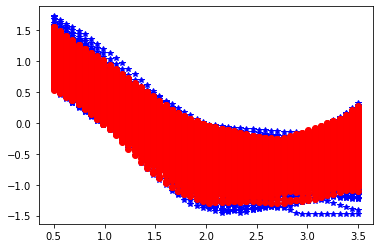

In [18]:
plt.figure()
cluster_num = 2
for i in range(num_samples):
    if learn.predict_labels[i] == cluster_num:
        plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
for i in range(num_obs):
    if learn.obs_labels[i] == cluster_num:
        plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [19]:
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=1)

3 principal components explain 98.5444% of variance for cluster 0 with {'kernel': 'linear'}
24 principal components explain 95.1097% of variance for cluster 0 with {'kernel': 'rbf'}
8 principal components explain 95.0665% of variance for cluster 0 with {'kernel': 'sigmoid'}
10 principal components explain 96.3345% of variance for cluster 0 with {'kernel': 'poly'}
3 principal components explain 97.1208% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'linear'}
1 principal components explain 55.3322% of variance.
2 principal components explain 98.3738% of variance for cluster 1 with {'kernel': 'linear'}
13 principal components explain 95.5726% of variance for cluster 1 with {'kernel': 'rbf'}
4 principal components explain 95.2402% of variance for cluster 1 with {'kernel': 'sigmoid'}
5 principal components explain 95.9723% of variance for cluster 1 with {'kernel': 'poly'}
3 principal components explain 99.3877% of variance for cluster 1 with {'

In [20]:
learn.generate_kdes()
learn.compute_r()

r values: [0.9859833034537158, 1.0337055497489327, 1.010132474982488]


[0.9859833034537158, 1.0337055497489327, 1.010132474982488]